## TRAINING on Counterparty Credit Risk ##
By Vincent Sin | Version 1.0, *2024-06*


---



# **DEMONSTRATION FOR COUNTERPARTY CREDIT RISK (CCR)**  #


|  |  |
|:---|:---|
|**Prior Knowledge** | Random numbers, Simulation, GBM, Vanilla derivative pricing, Wrong Way Risk |
|**Keywords** | PFE, Credit VaR, Stress Test, Net FX position |


---

*The presentation here is just for demonstrating some general concepts for counterparty credit risk. The examples below are under simplied models (especially for diffusion model) compared to the actual models implemented in the industry.* \
<span style='color: transparent; font-size:1%'>By Vincent Sin </span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import yfinance as yf

## **1. Counterparty Credit Risk (CCR)** ##

### **CCR is the Credit Risk of Market transaction.** ###

- **Non-market transaction**:
  - Commercial Banking transaction
  - e.g. Simple Loan,  Letter of Credit
  - Unilateral, only the lending/issuing bank face the risk of loss
  - Fixed amount/payoff, not subject to market parameters
  - Only has **Credit Risk** but not Market Risk
  
<!-- -->

- **Market transaction**:
  - Investment Banking transaction
  - e.g. Derivatives (Swap/Forward/Option) and Repos (Security Financing)
  - Bilateral, each **counterpart** could face the risk of loss
  - Variable payoff, which is subject to market parameters (e.g. FX rate, Interest rate, Equity price, Bond price)
  - Has both **Counterpart Credit Risk** and Market Risk
    - Market Risk: Negative payoff
    - Counterparty Credit Risk: **Positive payoff**, but our counterpart fails to pay i.e. **default**
    - Market Risk and CCR are in **opposite** direction.
    - e.g. If our bank buy an option, we have limited Market Risk, but could have substantial CCR.
  
### **It seems we just lose the chance of winning (positive payoff), but not losing money at all?** ###
As a sell side bank, we usually don't take directional exposure, and will try to hedge our position straigntaway once we trade with the initial counterpart. That's to say, we sell on one side (e.g. to Corporate / Hedge Fund clients) and at the same time buy on the other side (e.g. from a Broker).

Having a positive payoff against the client means we are incurring a negative payoff against the broker as well. If our client defaults, we can't receive the postive to net off, and thus incurring loses on the hedges.

### **How do we quantify CCR?** ###

- For **Market Risk**:
  - We use **Sensitivity** to quantify the **size of risk**
  - We use **Stress Testing / Sensi * Shock** to quantify the **size of loss**
  - For our daily PnL explanation, the "shock" is the daily move of the market parameter, and it is **backward-looking**.
  - Stress Testing is applying a **Spot Shock** to the market parameter, and consider the shocked MtM as of **today**.
    - The spot shock is based on "Scenario", which could be calibrated by historical data.
  - Market Risk management is more dynamic. We look at the whole trading book and dynamically hedge our position on daily basis, so as to handle the second order risk. There is not much of a concern to forecast the risk on a very long term, but rather to focus on the potential loss that we could suffer today or in a short period of time.

<!-- -->

- For **Counterparty Credit Risk**:
  - We could have "Spot" Sensitivity of a counterpart, to reflect the size of risk today (just like what we do for market risk).
  - In some local report we use metrics such as **Net FX Position** and **Cash at Risk for Security Financing** to quantify size of risk, which is kind of proxy of the sensitivity and jump to default loss.
  - We use both **Potential Future Exposure (PFE)** and Stress Testing to quantify the size of loss i.e. **CCR Exposure**
  
  - In simple wordings, **CCR exposure represents the current value (i.e. MtM) of the portfolio plus a potential movement**.
    - The potential movement could be modelled by either the PFE or Stress Test approach. We usually make conservative assumption when calculating this potential movement.



  - Stress Test part is same as Market Risk, where we apply **Spot Shock** to the market parameter, and consider the shocked MtM as of **today** after a **full-recomputation**
    - Again, the spot shock is calibrated based on some "Scenario", which could be calibrated by historical data.
      - E.g. Market parameters in the stressful period of 2008
    - CCR Stress Test examples includes:
      - a **Multi-factor** stress test (**STT_M**)
      - a **Single-factor** stress test (**STT_S**)



  - Potential Future Exposure (PFE) is a **forward-looking** metric, and it is a profile (i.e. different values for different time steps) instead of a single value (the case for stress test)
    - PFE looks at the **Mark-to-Future (MtF)** of the counterpart's portfolio, which is computed through **Monte-Carlo Simulation**, and take a certain percentile 
    - The percentile is usually conservatively taken as 95% to 99%.
      - In fact, it is not that "conservative", as when the counterpart defaults, it is probably under a stressful market. i.e. $ P(PFE_{99\%}) = 1\% $ but $ P(PFE_{99\%}|default) > 1\% $
        - i.e. we say PD and EAD has some correlation
      - Yet, please note **PFE does not depend on counterpart's credit profile** i.e. PFE is the same regardless of counterpart's rating (PD)
    - PFE metrics includes:
      - **Net Replacement Risk / Credit Value-at-Risk (CVaR)**, which is a bucketed 99% PFE that taken into account all collateral effect
      - **Gross Replacement Risk / Gross CVaR (GCVaR)**, which is the CVaR without taking into account Independent Amount, Initial Margin and Repo Haircut
      - **Stressed Country Replacement Risk **, which is the CVaR with additional shock based on country wrong way risk

<!-- -->

- For **Credit Risk**:
  - We say CCR is a sub-category of Credit Risk.
  - Both the PFE and Stress Test method introduced are trying to model the "Unexpected Credit Exposure".
  - We also have metrics like EEPE and CVA which try to capture the "Expected Credit Exposure".  Details will be described in later sections.

## **2. Monte-Carlo Simulation for modelling future exposure** ##

To understand better the concern, we will now go through an actual calculation under a simplified model.\
Summary of steps:
1. Define a diffusion process (model)
2. Calibrate the model parameters
3. Simulation of market parameter through Monte-Carlo method, with correlation embedded
4. Simulation of MtF for each path and time step, with all netting effect
5. Simulation of Collateral Balance from step 3 result
6. Computing Exposure matrix, with all collateral effect
7. Taking 99 percentile to obtain the PFE profile
8. Apply bucketing to obtain the CVaR profile

We will take an example of a **short position on an one month equity swap on Apple stock**.

### **(1) Define a diffusion process (model)** ##
A general idea of defining a diffusion process is:
- For a **Stationary** risk factor (e.g. interest rate), a long term trend exist and so we will use a **Mean-Reverting process** i.e. **Ornstein Uhlenbeck Model** (e.g. Vasicek Model)
- For a **Non-Stationary** risk factor (e.g. equity spot), we will use a Non mean-reverting process i.e. **Geometric Brownian Motion** (e.g. Black-Scholes Model)
- For commodities, specific models are designed. Please refer to GRM document for details.

Simple examples:
#### **Ornstein Uhlenbeck Model (OUM)** ####
$$ dr_t = k(\theta-r_t)dt + \sigma dW_t$$

Discretization (integration):
$$ r_t = r_0 e^{-kt} + \theta (1 - e^{-kt}) + \sqrt{\dfrac{\sigma^2}{2k}\left(1 - e^{-2kt} \right)}Z_t $$
$ Z_t \sim N(0,1) $

- $\theta$: long-term mean / mean
- $k$: speed of reversion
- $\sigma$: volatility of $r_t$
- $dW_t = \sqrt{dt} z$, with $z \sim \mathcal{N}(0,1)$
- $ r_t \sim \mathcal{N} \left(r_0 e^{-kt} + \theta (1 - e^{-kt}), \dfrac{\sigma^2}{2k}\left(1 - e^{-2kt} \right)\right)$

#### **Geometric Brownian Motion (GBM)** ####

$$ dS_t = \mu S_tdt + \sigma S_tdW_t $$
i.e. $ S_1 = S_0 + dS_0; S_2 = S_1 + dS_1; ... $

Discretization (integration):
$$ S_t = S_0 e^{\left(\mu - \frac{1}{2} \sigma^2\right)t + \sigma W_t} $$

- $\mu$: expected return
- $\sigma$: expected volatility
- $dW_t = \sqrt{dt} z$, with $z \sim \mathcal{N}(0,1)$
- $ ln S_t \sim \mathcal{N} \left(ln S_0 + \left(\mu - \frac{1}{2} \sigma^2\right)t, \sigma^2t\right)$


In market practise for option pricing, we could have many more complex models, such as Stochastic Volatility Model (Heston Model), Jump Diffusion Model (Merton Model), or even combine them as Stochastic Volatility Jump Model (Bates Model).

However, the more complex of the model, the more difficult to calibrate the model parameters. When considering computation cost and efficiency, it may worth for an investment model, but probably not worth for a risk management model.

As a bank with wide range of exposure, the diffusion model needs to calibrate tons of risk factors, and as well as the correlation between these risk factors. Therefore, to reduce the computational complexity and time, a bank may be implementing models which are closer to GBM and OUM, but are already very sophisticated when taking correlation into account.

In short, we could implement a Multifactorial Model, which split the risk into **Generic Risk** and **Specific Risk**. For example, we could model equity spot price through $\beta$ against some market indexes (e.g. S&P 500). A Prinpial Component Analysis (PCA) is run to get some independent factor, and then we will choose some observable generic risk factor (i.e. indexes) to represent that. As the correlation only need to be calibrated at generic risk factor level, it reduces greatly the dimention for the diffusion process.

Equity Spot example:
$$ dlnF_j\left(t\right)=\sigma_{F_j}dW_t $$
$$ \frac{dS_t}{S_t}=\left(r-q_D\right)dt+\Sigma_j\beta_jdlnF_j\left(t\right)+\sigma_{spec}dW_t $$

In our example, we will assume:
- A simple GBM with constant $\mu$ and constant $\sigma$ for Apple stock price
- A constant funding rate for discounting (no diffusion on interest rate)
  - i.e. flat term structure, continuously compounding

### **(2) Calibrate the model parameters** ##

To obtain the model parameters, we need to calibrate our model to the actual market price and volatility of the risk factor. We could choose to use 4 years of data history for quarterly calibration, which maintain both reactivity and steadiness. General idea for calibration as below.

### Drift ###
- For stationary process, long term average is taken as histoical mean of the time series
- For non-stationary process, it is simply the difference of the last and the first value of the time series

### Volatility ###
- Both risk-neutral approach and historical approach are possible solutions
- A bank may choose to use **historic volatility** for CCR model
  - Implied volatility is only observable in liquid market
  - Risk neutral parameters like long term volatility and correlation are not observable
  - Risk neutral may be good for pricing, but in fact not good for assessing risk
- Compute by volatility of historical daily return

### Correlation ###
- Computed by correlation of historical daily return
- We may captures correlation at generic risk factor level
- We may assumes zero correlation across different risk factor categories
  - e.g. no correlation between equity and commodity

In [2]:
# data = yf.download("AAPL", start="2019-01-01", end="2023-12-31")
data = yf.download("AAPL", period="4y")
price = data["Adj Close"]
daily_return = np.log(price/price.shift(1))
# daily_return = price/price.shift(1)-1
daily_vol = daily_return.std()
# annual_return = daily_return.mean() * 252
annual_vol = daily_vol * np.sqrt(252)
actual_return = np.log(price[-1]/price[0])
# actual_return = price[-1]/price[0]-1
annual_return = actual_return / 4
data_usd = yf.download("^IRX", period="4y")
rf = data_usd["Adj Close"]

print("Apple Annualized Average Return is: {:.2f}%".format(annual_return * 100),)
print("Apple Annualized Volatility is: {:.2f}%".format(annual_vol * 100))
print("USD risk free rate is: {:.2f}%".format(rf[-1]),)
print("Apple stock current price is: {:.2f}".format(price[-1]))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Apple Annualized Average Return is: 23.70%
Apple Annualized Volatility is: 33.58%
USD risk free rate is: 5.20%
Apple stock current price is: 194.17


For our simple GBM model, let's assume
- Constant $\mu$ = USD risk-free rate = 5%
- Constant $\sigma$ = 35%
- Constant USD discount rate = 5% = $\mu$

### **(3) Simulation of market parameter through Monte-Carlo method, with correlation embedded** ###

To simulate multiple risk factor, we would need to obtain their covariance matrix and apply in the simulation.

In our simple case, there is only one risk factor - Apple stock price, so we don't bother about the correlation here.

To simplify the demonstration, let's just simulate only 10 paths.

In [3]:
def GBM_simulate(S0, r, sigma, T, Ite):
    """
    S0: Current Stock Price
    r: Risk-free rate
    sigma: Volatility
    T: Maturity/time period (in years)
    M: Number of steps
    Ite: Number of simulations (paths)
    """
    dt = 1 / 365  # Time-step
    M = int(T * 365)
    SM = np.zeros((M + 1, Ite))
    SM[0] = S0

    # Random numbers
    z1 = np.random.standard_normal((M + 1, Ite))

    for t in range(1, M + 1):
        SM[t] = SM[t - 1] * (
            np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
        )
    return SM

In [4]:
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 30/365  # Maturity/time period (in years)

Ite = 10  # Number of simulations (paths)
dt = 1/365  # Time-step

In [5]:
np.random.seed(1)
stock_paths = GBM_simulate(S0, r, sigma, T, Ite)

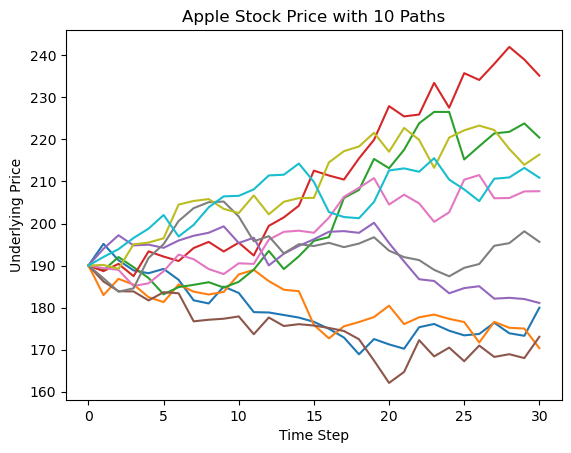

In [6]:
# plt.figure(figsize=(10, 8))
plt.plot(stock_paths)
plt.title("Apple Stock Price with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

### **(4) Simulation of MtF for each path and time step, with all netting effect** ##
Unlike market risk metrics where we consider all transactions in the desk as a whole, for CCR metric we need to consider at counterpart level, and we need to take into account all the features due to legal agreement for the counterpart.

One crucial point is that **netting** is only allowed within the same netting agreement. That's to say, trades under an ISDA master agreement (OTC derivatives) cannot be netted with trades under GRMA (Repos) or prime brokerage agreement.

In our simple case, there is only one trade, so no worries about netting. Let's simulate the MtF of a one month equity swap on Apple stock.

In [7]:
def equity_future(S, K, r, T, direction='long'):
    Ite = S.shape[1]
    M = S.shape[0] - 1
    dt = 1/365
    Tc = int(T * 365)
    
    fwd = np.flip(np.arange(Tc+1))
    fwd = np.exp(r*dt* fwd)
    fwd = np.pad(fwd, [(0, M-Tc)], mode='constant')
    fwd = np.transpose(np.full((Ite,M+1), fwd))
    
    if direction=='long':
        payoff = S * fwd - K
    else:
        payoff = K - S * fwd
    
    payoff[Tc+1:] = 0 # truncate after maturity
    
    return payoff * np.exp(-r * T)

In [8]:
K = S0 * np.exp(r * T) # Find strike price
MtF = equity_future(stock_paths, K, r, T, 'short')

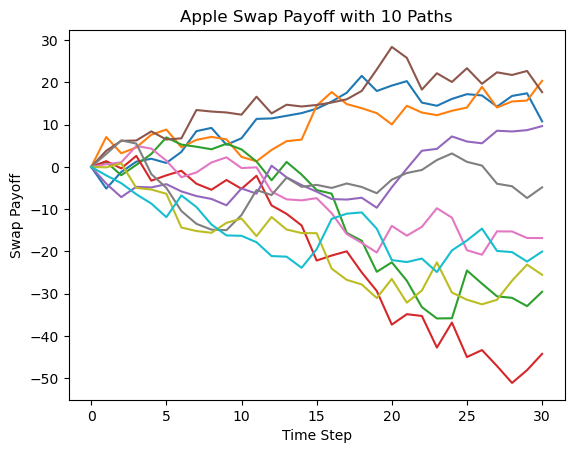

In [9]:
# plt.figure(figsize=(10, 8))
plt.plot(MtF)
plt.title("Apple Swap Payoff with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Swap Payoff")
plt.show()

### **(5) Simulation of Collateral Balance** ##

If we have signed a collateral agreement with the counterpart (e.g. CSA under an ISDA), then we could have received some **Variation Margin** (VM) during the life of the portfolio.

VM is a collateral to cover the credit risk from the current value of the portfolio (i.e. MtM). Its amount depends on the MtM of the trades, and also the **Threshold** and **MTA** (minimum transfer amount) of the CSA.

In a default scenario, let says the counterpart stop paying VM at D+0. After this first day, it could take us some time to go through the legal procedure and actual liquidation / replacement of the portfolio. At the end we only manage to settle everything at D+K. The time interval K is called the **Margin Period of Risk (MPOR)**.

We normally assume a 14-day MPOR for OTC derivatives and a 7-day MPOR for Repos. Why is the MPOR so long? We could imagine roughly:
- 1-3 days for margin dispute
  - E.g. challenge our MtM figures, using local holidays as excuse
- 1-3 days to confirm the counterpart actually default and confirm action plan
  - We need to discuss with counterpart to know if they actually has liquidity issue
  - Issuing default rightaway is not always the best solution, as it could create chain effect and trigger all the banks / broker to liquidate positions of the client, which could further stress the market liquidity risk
- 1-2 days for sending default notice and wait for grace period
- 1-3 days to liquidate or replace the porfolio. It could take time for illiquid market

All the above are in business days, so in calendar days we assume 14 days in general.

Therefore, the collateral balance at time t will be roughly the MtF at time t - 14 (depend on threshold and MTA). In our example we will assume 0 threshold and 0 MTA for easier illustration. Let's simulate the collateral balance.

In [10]:
MPOR = 14
Col_Bal = np.roll(MtF,MPOR,axis=0)
Col_Bal[:MPOR] = 0

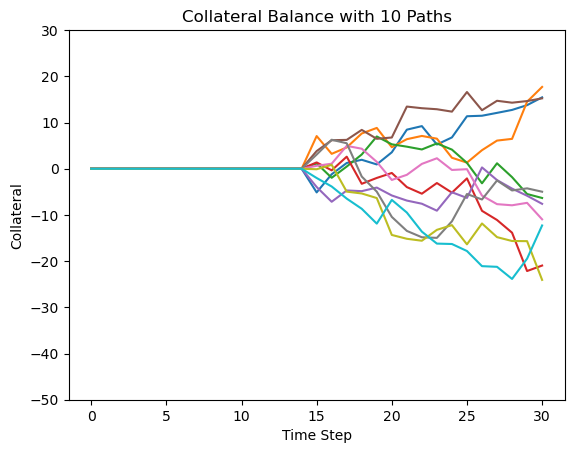

In [11]:
# plt.figure(figsize=(10, 8))
plt.plot(Col_Bal)
plt.title("Collateral Balance with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Collateral")
plt.ylim((-50, 30))
plt.show()

### **(6) Computing Exposure matrix, with all collateral effect** ##

After obtaining the simulation of collateral balance, our exposure will be the MtF minus the collateral. Please note that the VM we posted 14 days ago could become our exposure. Let say our MtM increases compared to 14 days ago, even though the total MtM of our portfolio is still negative, our counterpart is obligated to return some VM to us. If they can't return and default, then we are sufferring CCR loss here.

Let's see what we get in our example.

In [12]:
Expo = MtF - Col_Bal

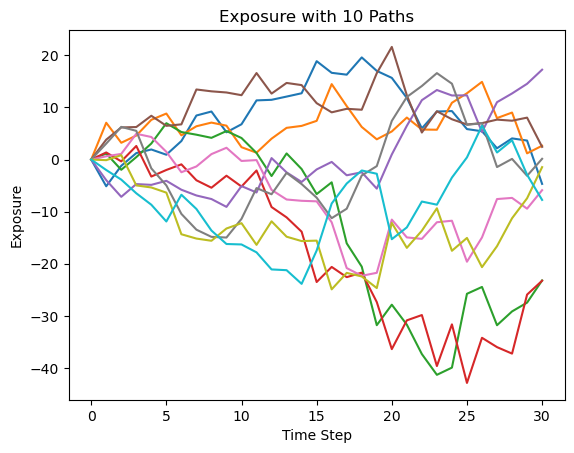

In [13]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.title("Exposure with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

### **(7) Obtain the 99\%tile PFE profile** ##

Now with the exposure matrix, we can take the 99 percentile to obtain the **Potential Future Exposure (PFE)** profile. Please note that in general the 99 percentile at each time step won't be coming from the same paths.

We may apply some smoothing technique in case we see some extreme value simulated.

Let's check on our example. For simplier illustration, we will look at the 90 percentile, which is the 9th largest path of out 10 at each time step.

In [14]:
PFE = np.percentile(Expo, 90, axis=1, method="closest_observation")

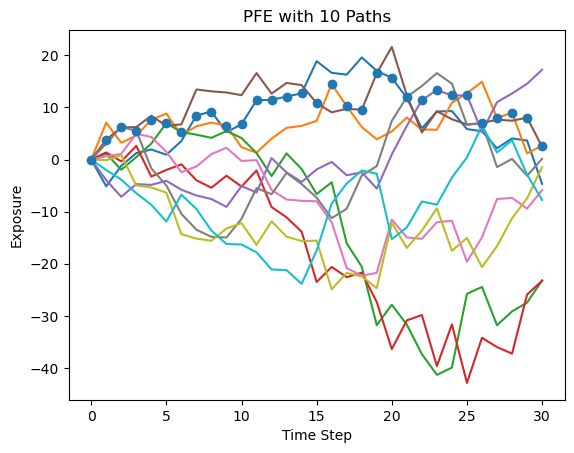

In [15]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "o")
plt.title("PFE with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

### **(8) Obtain CVaR** ##

Finally, we obtain the CVaR by bucketing the PFE and take the maximum value within each time bucket.

Let's check on our example.

In [16]:
CVaR = pd.DataFrame(np.array([[0,0]]), columns=['0d8d', '8d1m'])
CVaR["0d8d"] = np.max(PFE[:9])
CVaR["8d1m"] = np.max(PFE[9:31])
print(CVaR)

       0d8d       8d1m
0  9.222283  16.579084


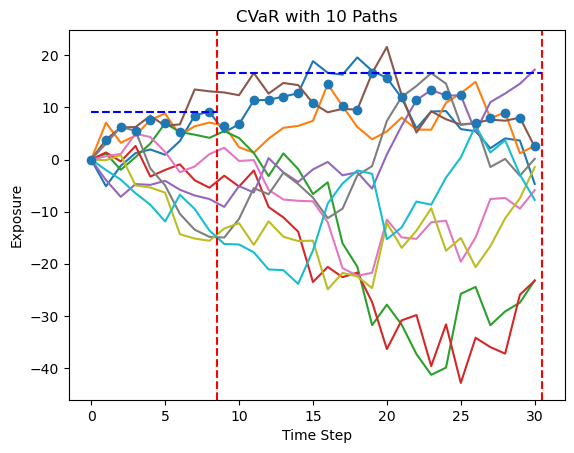

In [17]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "o")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.hlines(y = CVaR["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.title("CVaR with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

### Case with no CSA ###

For the case with no CSA, we just need to. ignore the colateral balance.
Let's see how it would go.

In [18]:
# Obtain Exposure matrix with no CSA
Expo_noCSA = MtF
# Obtain PFE profile with no CSA
PFE_noCSA = np.percentile(Expo_noCSA, 90, axis=1, method="closest_observation")
# Obtain CVaR profile with no CSA
CVaR_noCSA = pd.DataFrame(np.array([[0,0]]), columns=['0d8d', '8d1m'])
CVaR_noCSA["0d8d"] = np.max(PFE_noCSA[:9])
CVaR_noCSA["8d1m"] = np.max(PFE_noCSA[9:31])
print(CVaR_noCSA)

       0d8d      8d1m
0  9.222283  20.28278


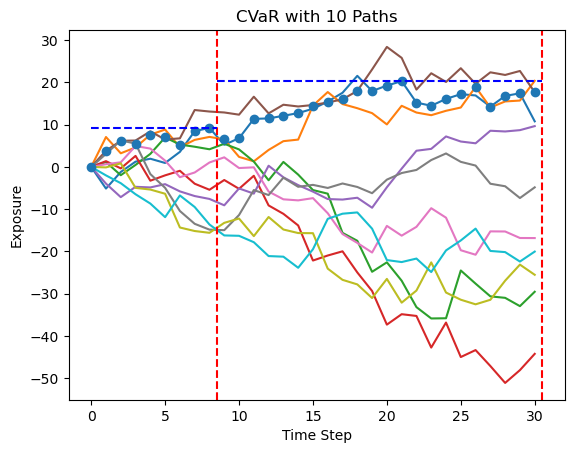

In [19]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo_noCSA)
plt.plot(PFE_noCSA, "o")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.hlines(y = CVaR_noCSA["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR_noCSA["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.title("CVaR with 10 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

The 8d1m bucket now has a higher CVaR. It is because now it can't benefit from collateral effect and there is no VM to offset the original MtF. Therefore, the CVaR is not capped as 14 days move, but the move could be up to as long as the maturity of the portfolio (30 days here).

### Extending the model to more paths ###

Great! We achieve to obtain the CVaR from our own simulation. Let's try to extend our example to 10,000 paths, and properly take 99 percentile this time.

Let's perform the whole computation again

In [20]:
# Define model parameters
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 30/365  # Maturity/time period (in years)

Ite = 10000  # Number of simulations (paths)
dt = 1/365  # Time-step

In [21]:
# Simulation of market parameter
np.random.seed(612)
stock_paths = GBM_simulate(S0, r, sigma, T, Ite)
# Simulation of MtF for each path and time step
K = S0 * np.exp(r * T) # Find strike price
MtF = equity_future(stock_paths, K, r, T, 'short')
# Simulation of Collateral Balance
MPOR = 14
Col_Bal = np.roll(MtF,MPOR,axis=0)
Col_Bal[:MPOR] = 0
# Computing Exposure matrix
Expo = MtF - Col_Bal
# Obtain PFE profile
PFE = np.percentile(Expo, 99, axis=1, method="closest_observation")
# Obtain CVaR profile
CVaR = pd.DataFrame(np.array([[0,0]]), columns=['0d8d', '8d1m'])
CVaR["0d8d"] = np.max(PFE[:9])
CVaR["8d1m"] = np.max(PFE[9:31])
print(CVaR)

        0d8d      8d1m
0  21.999707  29.40157


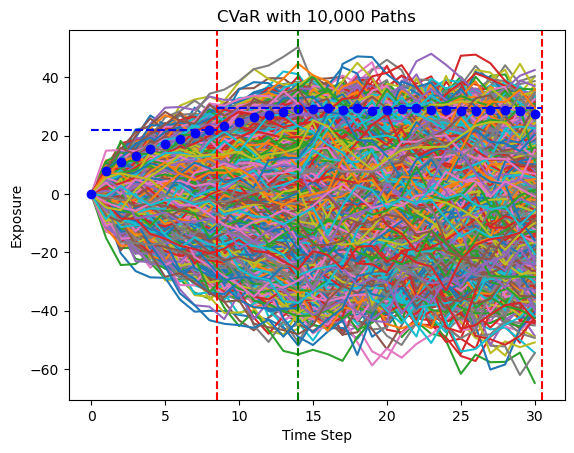

In [22]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "bo")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.axvline(x = MPOR, color="g", linestyle="dashed")
plt.hlines(y = CVaR["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.title("CVaR with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

Under a GBM setup, the log return of the stock will be symmetric.

We can see that after 14 days (MPOR, the green line), the CVaR stay around the same level. It is because after 14 days, the CVaR will always be capped as 14 days move.

For no CSA:

In [23]:
# Obtain Exposure matrix with no CSA
Expo_noCSA = MtF
# Obtain PFE profile with no CSA
PFE_noCSA = np.percentile(Expo_noCSA, 99, axis=1, method="closest_observation")
# Obtain CVaR profile with no CSA
CVaR_noCSA = pd.DataFrame(np.array([[0,0]]), columns=['0d8d', '8d1m'])
CVaR_noCSA["0d8d"] = np.max(PFE_noCSA[:9])
CVaR_noCSA["8d1m"] = np.max(PFE_noCSA[9:31])
print(CVaR_noCSA)

        0d8d       8d1m
0  21.999707  40.904238


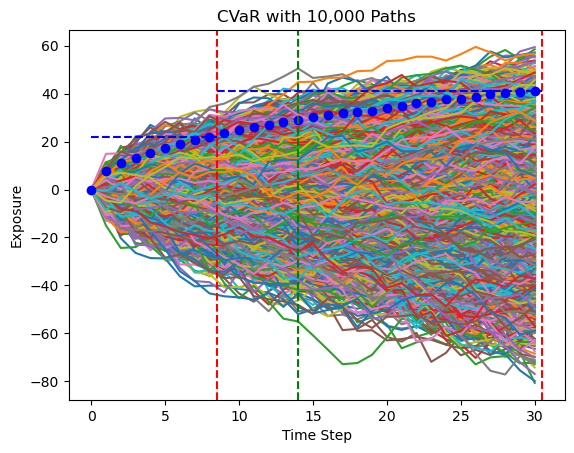

In [24]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo_noCSA)
plt.plot(PFE_noCSA, "bo")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.axvline(x = MPOR, color="g", linestyle="dashed")
plt.hlines(y = CVaR_noCSA["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR_noCSA["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.title("CVaR with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

Again, the CVaR is not capped as 14 days move (MPOR). The move could be up to as long as the maturity of the portfolio (30 days here)

## 3. Compare PFE (CVaR) to Stress Testing ##

As described in the first section:
  - Stress Test applies **Spot Shock** to the market parameter, and consider the shocked MtM as of **today**
  - Potential Future Exposure (PFE) is a **forward-looking** metric, and it is a profile (i.e. different values for different time steps) instead of a single value (the case for stress test)
  
To illustrate the concepts, we will try shocking our trade. By our diffusion model, we are assuming the stock price follows a lognormal distribution. First of all, let try a parametric approach.

In [25]:
def equity_future_one(S, K, r, T, direction='long'):
    fwd = np.exp(r * T)
    
    if direction=='long':
        payoff = S * fwd - K
    else:
        payoff = K - S * fwd
    
    return payoff * np.exp(-r * T)

In [26]:
print("Parametric Approach:")
print("Z-value for 1 percentile is: {:.2f}".format(ss.norm.ppf(0.01)))

K = S0 * np.exp(r * T) # Find strike price
MtM = equity_future_one(S0, K, r, T, 'short')
print("Initial MtM is : {:.4f}".format(MtM))

shock_period = 8/365
S8 = S0 * np.exp((r - 0.5 * sigma**2) * shock_period + sigma * np.sqrt(shock_period) * ss.norm.ppf(0.01))
MtM = equity_future_one(S8, K, r, T, 'short')
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
print("Shocked Price: {:.2f}".format(S8))
print("Shock log return %: {:.2f}%".format(np.log(S8/S0)*100))
print("Shock simple return %: {:.2f}%".format((S8-S0)/S0*100))
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period * 365, MtM))

shock_period = 14/365
S14 = S0 * np.exp((r - 0.5 * sigma**2) * shock_period + sigma * np.sqrt(shock_period) * ss.norm.ppf(0.01))
MtM = equity_future_one(S14, K, r, T, 'short')
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
print("Shocked Price: {:.2f}".format(S14))
print("Shock log return %: {:.2f}%".format(np.log(S14/S0)*100))
print("Shock simple return %: {:.2f}%".format((S14-S0)/S0*100))
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period * 365, MtM))

shock_period = 30/365
S30 = S0 * np.exp((r - 0.5 * sigma**2) * shock_period + sigma * np.sqrt(shock_period) * ss.norm.ppf(0.01))
MtM = equity_future_one(S30, K, r, T, 'short')
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
print("Shocked Price: {:.2f}".format(S30))
print("Shock log return %: {:.2f}%".format(np.log(S30/S0)*100))
print("Shock simple return %: {:.2f}%".format((S30-S0)/S0*100))
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period * 365, MtM))


Parametric Approach:
Z-value for 1 percentile is: -2.33
Initial MtM is : 0.0000
-------------------- 8 days shock --------------------------
Shocked Price: 168.38
Shock log return %: -12.08%
Shock simple return %: -11.38%
Stressed MtM with 99 percentile 8 days shock is: 21.6181
-------------------- 14 days shock --------------------------
Shocked Price: 161.92
Shock log return %: -15.99%
Shock simple return %: -14.78%
Stressed MtM with 99 percentile 14 days shock is: 28.0756
-------------------- 30 days shock --------------------------
Shocked Price: 150.31
Shock log return %: -23.44%
Shock simple return %: -20.89%
Stressed MtM with 99 percentile 30 days shock is: 39.6946


This parametric approach gives an very close result compare our previous simulation. As the portfolio in our example is very simple, so it is easy to apply this parametric approach.

The approach used in stress testing is in fact different. We define a **scenario**, where the shocks are calibrated by some **historical data**.\
Let's try to calibrate the shock with the last 4 years of historical data, just like the CVaR approach.

In [27]:
print("Historical Approach:")
shock_period = 8
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_8d = np.log(price/price.shift(shock_period))
Historical_99p_4y_8d = np.percentile(return_8d.dropna(), 1, method="closest_observation")
S8 = S0 * np.exp(Historical_99p_4y_8d)
print("Shocked Price: {:.2f}".format(S8))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_8d * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_8d)-1) * 100))
MtM = equity_future_one(S8, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))


shock_period = 14
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_14d = np.log(price/price.shift(shock_period))
Historical_99p_4y_14d = np.percentile(return_14d.dropna(), 1, method="closest_observation")
S14 = S0 * np.exp(Historical_99p_4y_14d)
print("Shocked Price: {:.2f}".format(S14))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_14d * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_14d)-1) * 100))
MtM = equity_future_one(S14, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))


shock_period = 30
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_30d = np.log(price/price.shift(shock_period))
Historical_99p_4y_30d = np.percentile(return_30d.dropna(), 1, method="closest_observation")

S30 = S0 * np.exp(Historical_99p_4y_30d)
print("Shocked Price: {:.2f}".format(S30))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_30d * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_30d)-1) * 100))
MtM = equity_future_one(S30, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))

Historical Approach:
-------------------- 2920 days shock --------------------------
Shocked Price: 164.81
99 percentile 8 days movement (log) in last 4 years is: -14.22%
99 percentile 8 days movement (simple) in last 4 years is: -13.26%
Stressed MtM with 99 percentile 8 days shock is: 25.1881
-------------------- 5110 days shock --------------------------
Shocked Price: 160.18
99 percentile 14 days movement (log) in last 4 years is: -17.07%
99 percentile 14 days movement (simple) in last 4 years is: -15.69%
Stressed MtM with 99 percentile 14 days shock is: 29.8200
-------------------- 10950 days shock --------------------------
Shocked Price: 146.52
99 percentile 30 days movement (log) in last 4 years is: -25.99%
99 percentile 30 days movement (simple) in last 4 years is: -22.88%
Stressed MtM with 99 percentile 30 days shock is: 43.4806


We can see the result is not too far from our previous simulation but does have difference. It is expected to have some differences as we know stock returns are in fact **not following Normal distribution**. In general they should have heavier tails and excess kurtosis.

We can plot the stressed MtM with spot shock (parametric approach) and the PFE together to have a clear view.

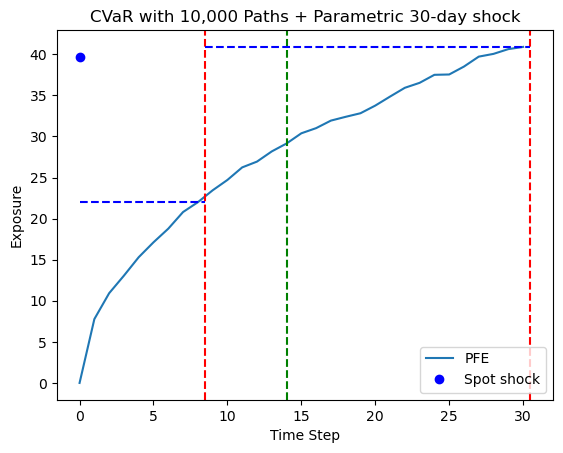

In [28]:
shock_period = 30/365
S30 = S0 * np.exp((r - 0.5 * sigma**2) * shock_period + sigma * np.sqrt(shock_period) * ss.norm.ppf(0.01))
MtM = equity_future_one(S30, K, r, T, 'short')

# plt.figure(figsize=(10, 8))
plt.plot(PFE_noCSA)
plt.plot(MtM, "bo")
plt.legend(["PFE","Spot shock"], loc ="lower right")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.axvline(x = MPOR, color="g", linestyle="dashed")
plt.hlines(y = CVaR_noCSA["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR_noCSA["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.title("CVaR with 10,000 Paths + Parametric 30-day shock")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

The level from the spot shock is the same as the 3m CVaR. **Here we can see that ideas for both PFE and Stress Test are in fact very similar.** CVaR could be thought of having one more dimension, which we look into future time.

In our usual stress testing, we will in fact define our scenario based on a **stressful period**. For example, a scenario could be calibrated with data from the Global Financial Crisis. Let's see how it looks like if we calibrate our shock using data in period 2008-09-02 to 2009-09-02.

In [30]:
data_S = yf.download("AAPL", start="2018-09-02", end="2019-09-02")
price_S = data_S["Adj Close"]

print("Historical Approach, with stressful period in 2008-2009:")
shock_period = 8
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_8d_S = np.log(price_S/price_S.shift(shock_period))
Historical_99p_4y_8d_S = np.percentile(return_8d_S.dropna(), 1, method="closest_observation")
S8 = S0 * np.exp(Historical_99p_4y_8d_S)
print("Shocked Price: {:.2f}".format(S8))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_8d_S * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_8d_S)-1) * 100))
MtM = equity_future_one(S8, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))


shock_period = 14
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_14d_S = np.log(price_S/price_S.shift(shock_period))
Historical_99p_4y_14d_S = np.percentile(return_14d_S.dropna(), 1, method="closest_observation")
S14 = S0 * np.exp(Historical_99p_4y_14d_S)
print("Shocked Price: {:.2f}".format(S8))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_14d_S * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_14d_S)-1) * 100))
MtM = equity_future_one(S14, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))


shock_period = 30
print("-------------------- {:.0f} days shock --------------------------".format(shock_period * 365))
return_30d_S = np.log(price_S/price_S.shift(shock_period))
Historical_99p_4y_30d_S = np.percentile(return_30d_S.dropna(), 1, method="closest_observation")
S30 = S0 * np.exp(Historical_99p_4y_30d_S)
print("Shocked Price: {:.2f}".format(S8))
print("99 percentile {:.0f} days movement (log) in last 4 years is: {:.2f}%".format(shock_period, Historical_99p_4y_30d_S * 100))
print("99 percentile {:.0f} days movement (simple) in last 4 years is: {:.2f}%".format(shock_period, (np.exp(Historical_99p_4y_30d_S)-1) * 100))
MtM = equity_future_one(S30, K, r, T, 'short')
print("Stressed MtM with 99 percentile {:.0f} days shock is: {:.4f}".format(shock_period, MtM))

[*********************100%***********************]  1 of 1 completed
Historical Approach, with stressful period in 2008-2009:
-------------------- 2920 days shock --------------------------
Shocked Price: 164.27
99 percentile 8 days movement (log) in last 4 years is: -14.55%
99 percentile 8 days movement (simple) in last 4 years is: -13.54%
Stressed MtM with 99 percentile 8 days shock is: 25.7304
-------------------- 5110 days shock --------------------------
Shocked Price: 164.27
99 percentile 14 days movement (log) in last 4 years is: -22.53%
99 percentile 14 days movement (simple) in last 4 years is: -20.17%
Stressed MtM with 99 percentile 14 days shock is: 38.3242
-------------------- 10950 days shock --------------------------
Shocked Price: 164.27
99 percentile 30 days movement (log) in last 4 years is: -32.79%
99 percentile 30 days movement (simple) in last 4 years is: -27.96%
Stressed MtM with 99 percentile 30 days shock is: 53.1168


The shocks are higher compared to what we got from last 4 years data. This is in fact the purpose of stress testing, we want to define a **conservative scenario** and see if our bank can still survive in this doom stage.\
Therefore, we could expect the stressed exposure to be higher than the one from CVaR.

#### When the spirits for both PFE and Stress testing are similar, why do we bother to have "duplicated" metrics? ####
These two types of metrics can in fact **complement** each other.

Stress Testing is more convincing in general, as the definition of scenario is **clear**, the shock calibration from historical data **does not require heavy modelling assumption** (while PFE does), and computation from full repricing of MtM is **easy to understand** (while PFE looks at MtF, which could be sometime confusing).

This "spot shock" approach is all good for Market Risk Management. As we can perform the hedging dynamically, we could just look within a short period of time. However, for Counterparty Credit Risk management, we have to consider some **potential future scenarios**.

To illustrate the problem, let's see a few examples below.

#### **Example 1 - Offsetting positions with different maturities** ####

For two offsetting trades with different maturity, if the counterpart doesn't trade further in the future, it will happen in a period where one trade has matured, and we are left with a high exposure without the offsetting trade.

Let's add a long position of equity swap on Apple stock with 3 month tenor and slightly smaller quantity to our previous example, and we take a strike of $150 for both trades.

In [31]:
# Define model parameters
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 30/365  # Maturity/time period (in years)
T2 = 90/365
quantity = 1000
quantity2 = 950
notional = S0*quantity

Ite = 10000  # Number of simulations (paths)
dt = 1 / 365  # Time-step

K = 150

First, we try with the stress testing approach.

In [32]:
data_S = yf.download("AAPL", start="2018-09-02", end="2019-09-02")
price_S = data_S["Adj Close"]
shock_period = 90
return_90d_S = np.log(price_S/price_S.shift(shock_period))
Historical_99p_4y_90d_S_up = np.percentile(return_30d_S.dropna(), 99, method="closest_observation")
Historical_99p_4y_90d_S_down = np.percentile(return_30d_S.dropna(), 1, method="closest_observation")

S_up = S0 * np.exp(Historical_99p_4y_90d_S_up)
S_down = S0 * np.exp(Historical_99p_4y_90d_S_down)

MtM = equity_future_one(S0, K, r, T, 'short')*quantity + equity_future_one(S0, K, r, T2, 'long')*quantity2
MtM_up = equity_future_one(S_up, K, r, T, 'short')*quantity + equity_future_one(S_up, K, r, T2, 'long')*quantity2
MtM_down = equity_future_one(S_down, K, r, T, 'short')*quantity + equity_future_one(S_down, K, r, T2, 'long')*quantity2

print("Notional is: ${:,.0f}".format(notional))
print("Initial MtM is: {:.2f}".format(MtM))
print("Conservative shocks (log) for up and down are: {:.2f}% and {:.2f}%".format(Historical_99p_4y_90d_S_up*100, Historical_99p_4y_90d_S_down*100))
print("Conservative shocks (simple) for up and down are: {:.2f}% and {:.2f}%".format((np.exp(Historical_99p_4y_90d_S_up)-1)*100, (np.exp(Historical_99p_4y_90d_S_down)-1)*100))
print("Stressed MtM with 99 percentile {:.0f} days up and down shocks are: {:.2f} and {:.2f}".format(shock_period, MtM_up, MtM_down))
print("The stress impacts are: {:.2f}% and {:.2f}% of notional".format((MtM_up - MtM)/notional*100, (MtM_down - MtM)/notional*100))

[*********************100%***********************]  1 of 1 completed
Notional is: $190,000
Initial MtM is: -869.11
Conservative shocks (log) for up and down are: 16.70% and -32.79%
Conservative shocks (simple) for up and down are: 18.18% and -27.96%
Stressed MtM with 99 percentile 90 days up and down shocks are: -2596.18 and 1786.73
The stress impacts are: -0.91% and 1.40% of notional


Since the current position is netted to close to 0 delta, even we apply a conservative spot shock, the impact is just minimal.

Next, let's check the PFE case.

In [33]:
# Simulation of market parameter
np.random.seed(612)
stock_paths = GBM_simulate(S0, r, sigma, T2, Ite)
# Simulation of MtF for each path and time step

MtF1 = equity_future(stock_paths, K, r, T, 'short')*quantity
MtF2 = equity_future(stock_paths, K, r, T2, 'long')*quantity2
MtF = MtF1 + MtF2
# Simulation of Collateral Balance
MPOR = 14
Col_Bal = np.roll(MtF,MPOR,axis=0)
Col_Bal[:MPOR] = 0
# Computing Exposure matrix
Expo = MtF - Col_Bal
# Obtain PFE profile
PFE = np.percentile(Expo, 99, axis=1, method="closest_observation")
# Obtain CVaR profile
CVaR = pd.DataFrame(np.array([[0,0,0]]), columns=['0d8d', '8d1m', '1m3m'])
CVaR["0d8d"] = np.max(PFE[:9])
CVaR["8d1m"] = np.max(PFE[9:31])
CVaR["1m3m"] = np.max(PFE[31:91])
print(CVaR)

         0d8d         8d1m          1m3m
0  230.875726  1470.078521  98959.792355


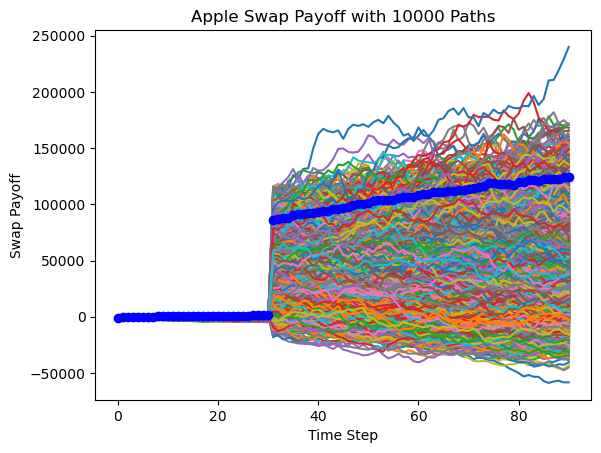

MtF at 1m3m bucket is: 124,745, 66% of notional.


In [34]:
# Obtain PFE profile
PFE_noCSA = np.percentile(MtF, 99, axis=1, method="closest_observation")

plt.plot(MtF)
plt.plot(PFE_noCSA, "bo")
plt.title("Apple Swap Payoff with 10000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Swap Payoff")
plt.show()

print("MtF at 1m3m bucket is: {:,.0f}, {:.0f}% of notional.".format(np.max(PFE_noCSA[31:91]), np.max(PFE_noCSA[31:91])/notional *100))

If we look at the portfolio as whole (before collateral), before D+30, the two positions net off and net exposure is around zero. However, after D+30, as the first trade has matured, we are left with the remaining long position (66%), which in fact give us a huge exposure. This is the **potential future scenario** that we should consider, as we may not be able to hedge our position with same counterpart.

And let's see the case with CSA.

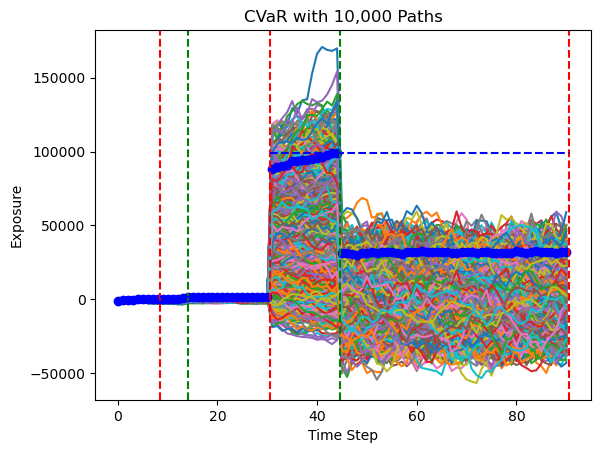

CVaR at 1m3m bucket is: 98,960, 52% of notional.


In [35]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "bo")
plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.axvline(x = 90.5, color="r", linestyle="dashed")
plt.axvline(x = MPOR, color="g", linestyle="dashed")
plt.axvline(x = 30.5 + MPOR, color="g", linestyle="dashed")
plt.hlines(y = CVaR["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["1m3m"], xmin=30.5, xmax=90.5, color='b', linestyle="dashed")
plt.title("CVaR with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

print("CVaR at 1m3m bucket is: {:,.0f}, {:.0f}% of notional.".format(CVaR.loc[0,"1m3m"], CVaR.loc[0,"1m3m"]/notional *100))

Even after considering collateral, we still have a period with high exposure (52%). Before D+30, as our position is netted to around 0, we will not receive much VM. Therefore, betweem D+30 to D+44 (MPOR), we are not really protected by VM.

It is clear that in this kind of cases stress testing is not good enough as it can't spot the change of portfolio in future time. Therefore, it is important to have CVaR as a complement.

#### **Example 2 - Position with Gamma** ####

For a deeply OTM option, the delta is close to 0. Therefore, even though we apply a conservative spot shock, the impact will be smaller. However, in some future scenaio, the option could have become more and more ITM, and the delta will move closer to 1. The portfolio will be sensitive to the underlying shock and we could be exposed to a high CCR exposure.

Let's consider long position on an OTM (200% strike) call option on Apple stock, with 1 year tenor. We assume trade under CSA with 14 days MPOR.

In [36]:
# Define model parameters
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 2  # Maturity/time period (in years)
quantity = 1000
notional = S0*quantity

Ite = 10000  # Number of simulations (paths)
dt = 1 / 365  # Time-step

K = S0 * 2
print(K)

380


First, we try with the stress testing approach. We will simply use Black-Scholes model to price.

In [37]:
def bs_option_price(S, r, vol, T, K, option_type="call"):
    # Compute d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    if option_type in ["C", "P", "call", "put"]:
        if option_type in ["C", "call"]:
            Opt_Price = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
        else:
            Opt_Price = K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
    else:
        Opt_Price = "Error: option type incorrect. Choose P for a put option or C for a call option."
    return Opt_Price

In [38]:
shock_period = 14
return_14d = np.log(price/price.shift(shock_period))
Historical_99p_4y_14d = np.percentile(return_14d.dropna(), 99, method="closest_observation")

S_up = S0 * np.exp(Historical_99p_4y_14d)

MtM = bs_option_price(S0, r, sigma, T, K, "call")*quantity
MtM_up = bs_option_price(S_up, r, sigma, T, K, "call")*quantity

print("Notional is: ${:,.0f}".format(notional))
print("Initial MtM is: ${:,.0f}".format(MtM))
print("Conservative shocks (log): {:.2f}%".format(Historical_99p_4y_14d*100))
print("Conservative shocks (simple): {:.2f}%".format((np.exp(Historical_99p_4y_14d)-1)*100))
print("Stressed stock price: ${:,.0f}".format(S_up))
print("Strike price: ${:,.0f}".format(K))
print("Stressed MtM with 99 percentile {:.0f} days shocks: ${:,.0f}".format(shock_period, MtM_up))
print("The stress impact: ${:,.0f}, {:.2f}% of notional".format(MtM_up - MtM, (MtM_up - MtM)/notional*100))

Notional is: $190,000
Initial MtM is: $6,977
Conservative shocks (log): 16.29%
Conservative shocks (simple): 17.70%
Stressed stock price: $224
Strike price: $380
Stressed MtM with 99 percentile 14 days shocks: $14,314
The stress impact: $7,337, 3.86% of notional


Since the delta is just low for OTM option, even we apply a conservative spot shock, the impact is still not significant.

Now, let's see what we get by PFE.

In [39]:
def equity_option(S, K, r, T, direction='long', option_type="call"):
    Ite = S.shape[1]
    M = S.shape[0] - 1
    dt = 1/365
    Tc = int(T * 365)
    
    fwd = np.flip(np.arange(Tc+1))
    fwd = np.exp(r*dt* fwd)
    fwd = np.pad(fwd, [(0, M-Tc)], mode='constant')
    fwd = np.transpose(np.full((Ite,M+1), fwd))
    
    if direction=='long':
        position = 1
    else:
        position = -1
    
    if option_type=="call":
        payoff = S * fwd - K
    else:
        payoff = K - S * fwd
        
    payoff[payoff < 0] = 0
    payoff = payoff * position
    
    payoff[Tc+1:] = 0 # truncate after maturity

    return payoff * np.exp(-r * T)

In [40]:
# Simulation of market parameter
np.random.seed(612)
stock_paths = GBM_simulate(S0, r, sigma, T, Ite)
# Simulation of MtF for each path and time step
MtF = equity_option(stock_paths, K, r, T, 'long', 'call') * quantity
# Simulation of Collateral Balance
MPOR = 14
Col_Bal = np.roll(MtF,MPOR,axis=0)
Col_Bal[:MPOR] = 0
# Computing Exposure matrix
Expo = MtF - Col_Bal
# Obtain PFE profile
PFE = np.percentile(Expo, 99, axis=1, method="closest_observation")
# Obtain CVaR profile
CVaR = pd.DataFrame(np.array([[0,0,0,0,0,0]]), columns=['0d8d', '8d1m', '1m3m', '3m6m', '6m1y', '1y2y'])
CVaR["0d8d"] = np.max(PFE[:9])
CVaR["8d1m"] = np.max(PFE[9:31])
CVaR["1m3m"] = np.max(PFE[31:91])
CVaR["3m6m"] = np.max(PFE[91:181])
CVaR["6m1y"] = np.max(PFE[181:366])
CVaR["1y2y"] = np.max(PFE[366:731])
print(CVaR)

   0d8d  8d1m  1m3m  3m6m          6m1y          1y2y
0   0.0   0.0   0.0   0.0  15675.151715  35321.699924


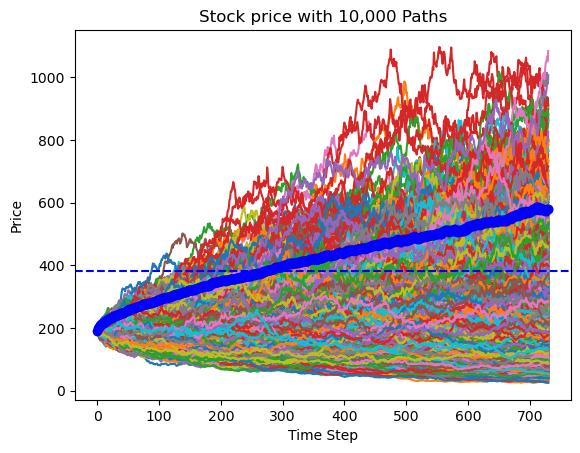

In [41]:
PFE_stock = np.percentile(stock_paths, 99, axis=1, method="closest_observation")

plt.plot(stock_paths)
plt.plot(PFE_stock, "bo")
plt.axhline(y = K, color='b', linestyle="dashed")
plt.title("Stock price with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

From stock price, we see even though initially the option is OTM, around after 1y of simulation, the 99% tile case becomes ITM.

Let's see the PFE with no CSA:

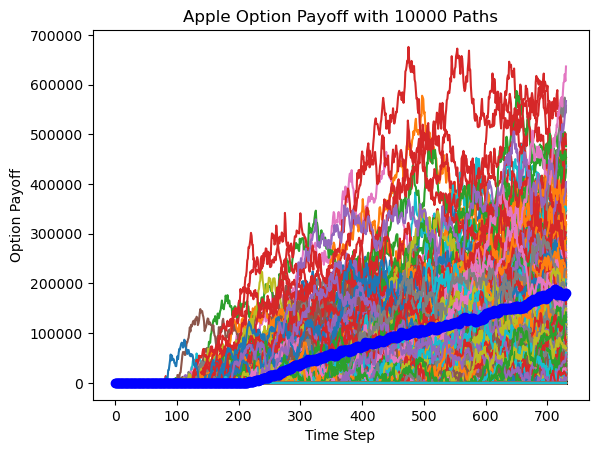

PFE (No CSA) at 1y2y bucket is: 188,054, 99% of notional.


In [42]:
# Obtain PFE profile
PFE_noCSA = np.percentile(MtF, 99, axis=1, method="closest_observation")

plt.plot(MtF)
plt.plot(PFE_noCSA, "bo")
plt.title("Apple Option Payoff with 10000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Option Payoff")
plt.show()

print("PFE (No CSA) at 1y2y bucket is: {:,.0f}, {:.0f}% of notional.".format(np.max(PFE_noCSA[366:731]), np.max(PFE_noCSA[366:731])/notional *100))

And the normal CVaR will be:

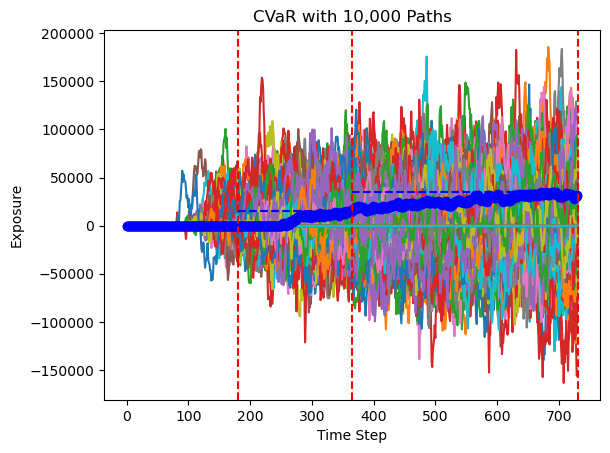

CVaR at 1y2y bucket is: 35,322, 19% of notional.


In [43]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "bo")
plt.axvline(x = 180.5, color="r", linestyle="dashed")
plt.axvline(x = 365.5, color="r", linestyle="dashed")
plt.axvline(x = 730.5, color="r", linestyle="dashed")

plt.hlines(y = CVaR["6m1y"], xmin=180.5, xmax=365.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["1y2y"], xmin=365.5, xmax=730.5, color='b', linestyle="dashed")
plt.title("CVaR with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

print("CVaR at 1y2y bucket is: {:,.0f}, {:.0f}% of notional.".format(CVaR.loc[0,"1y2y"], CVaR.loc[0,"1y2y"]/notional *100))

As the option is deeply OTM, even we apply a conservative shock, the stressed stock price is still far from the strike. However, if we allow it to diffuse, we can see after one year the 99 percentile is already greater than the strike, thus now the delta is >50% and is much more sensitive to subsequent shock.

The 2Y CVaR is actually 5 times the stress test result. This can alert us the potential high exposure we could have.

Again, for this kind of case stress testing is not good enough as it doesn't consider a potential future scenario that the delta of the position has grown to a much higher level. Therefore, it is important to have CVaR as a complement.

#### **Example 3 - Payoff in Specific Range** ####

For some option strategy (e.g. Butterfly Spread) or some products with exotic payoff (e.g. Range Accrual, Dual Digital), we could only have position payoff when the underlying price is within a specific range.

Let's consider a long position on an Butterfly Spread on Apple stock, with a 10% range around spot and 1 month tenor. We assume trade under CSA with 14 days MPOR.

In [44]:
# Define model parameters
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 1/12  # Maturity/time period (in years)
quantity = 1000
notional = S0*quantity

Ite = 10000  # Number of simulations (paths)
dt = 1 / 365  # Time-step

K1 = S0 * 0.95
K2 = S0
K3 = S0 * 1.05

First, let's check the payoff graph:

In [45]:
def getPayoff_butterfily(S, K1, K2, K3):
        if S > K1 and S<= K2:
            return S - K1
        elif S > K2 and S<= K3:
            return K3 - S
        else:
            return 0
        
def addPayoff_butterfily(K1, K2, K3, rng=30):
    stockP = range(K2 - rng, K2 + rng)
    OptionP = list(map(lambda a: getPayoff_butterfily(S=a, K1=K1, K2=K2, K3=K3), stockP))
    plt.plot(stockP, OptionP)
    plt.title("Payoff of a butterfly spread")

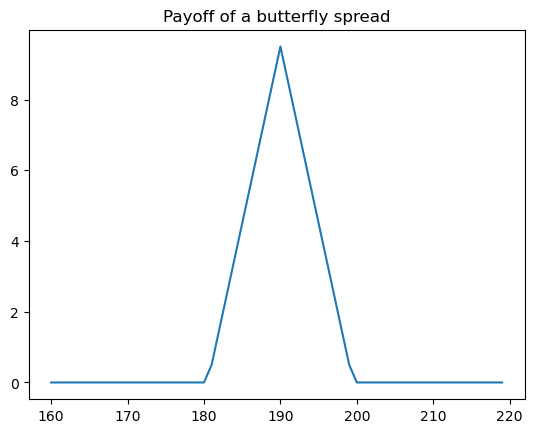

In [46]:
addPayoff_butterfily(K1, K2, K3)

Next, we try with the stress testing approach. We will simply use Black-Scholes model to price.

In [47]:
def bs_option_price(S, r, vol, T, K, option_type="call"):
    # Compute d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    if option_type in ["C", "P", "call", "put"]:
        if option_type in ["C", "call"]:
            Opt_Price = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
        else:
            Opt_Price = K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
    else:
        Opt_Price = "Error: option type incorrect. Choose P for a put option or C for a call option."
    return Opt_Price

In [48]:
def bs_butterfly_price(S, r, vol, T, K1, K2, K3):
    return bs_option_price(S, r, vol, T, K1, option_type="call") - 2 * bs_option_price(S, r, vol, T, K2, option_type="call") + bs_option_price(S, r, vol, T, K3, option_type="call")

In [49]:
shock_period = 14
return_14d = np.log(price/price.shift(shock_period))
Historical_99p_4y_14d = np.percentile(return_14d.dropna(), 99, method="closest_observation")

S_up = S0 * np.exp(Historical_99p_4y_14d)

MtM = bs_butterfly_price(S0, r, sigma, T, K1, K2, K3)*quantity

MtM_up = bs_butterfly_price(S_up, r, sigma, T, K1, K2, K3)*quantity

print("Notional is: ${:,.0f}".format(notional))
print("Initial MtM is: ${:,.0f}".format(MtM))
print("Conservative shocks (log): {:.2f}%".format(Historical_99p_4y_14d*100))
print("Conservative shocks (simple): {:.2f}%".format((np.exp(Historical_99p_4y_14d)-1)*100))
print("Stressed stock price: ${:,.0f}".format(S_up))
print("Strike price: ${:,.0f}, ${:,.0f}, ${:,.0f}".format(K1, K2, K3))
print("Stressed MtM with 99 percentile {:.0f} days shocks: ${:,.0f}".format(shock_period, MtM_up))
print("The stress impact: ${:,.0f}, {:.2f}% of notional".format(MtM_up - MtM, (MtM_up - MtM)/notional*100))

Notional is: $190,000
Initial MtM is: $1,831
Conservative shocks (log): 16.29%
Conservative shocks (simple): 17.70%
Stressed stock price: $224
Strike price: $180, $190, $200
Stressed MtM with 99 percentile 14 days shocks: $528
The stress impact: $-1,304, -0.69% of notional


We can see after the shock, our exposure even decreases! It is because we are further away from the profitable range.

Now, let's see what we get by PFE.

In [50]:
def equity_butterfly_option(S, K1, K2, K3, r, T):
    Ite = S.shape[1]
    M = S.shape[0] - 1
    dt = 1/365
    Tc = int(T * 365)
    
    fwd = np.flip(np.arange(Tc+1))
    fwd = np.exp(r*dt* fwd)
    fwd = np.pad(fwd, [(0, M-Tc)], mode='constant')
    fwd = np.transpose(np.full((Ite,M+1), fwd))
    
    payoff1 = S * fwd - K1
    payoff1[payoff1 < 0] = 0
    payoff2 = S * fwd - K2
    payoff2[payoff2 < 0] = 0
    payoff3 = S * fwd - K3
    payoff3[payoff3 < 0] = 0
    
    payoff = payoff1 - 2 * payoff2 + payoff3
    payoff[Tc+1:] = 0 # truncate after maturity

    return payoff * np.exp(-r * T)

In [51]:
# Simulation of market parameter
np.random.seed(612)
stock_paths = GBM_simulate(S0, r, sigma, T, Ite)
# Simulation of MtF for each path and time step
MtF = equity_butterfly_option(stock_paths, K1, K2, K3, r, T) * quantity
# Simulation of Collateral Balance
MPOR = 14
Col_Bal = np.roll(MtF,MPOR,axis=0)
Col_Bal[:MPOR] = 0
# Computing Exposure matrix
Expo = MtF - Col_Bal
# Obtain PFE profile
PFE = np.percentile(Expo, 99, axis=1, method="closest_observation")
# Obtain CVaR profile
CVaR = pd.DataFrame(np.array([[0,0]]), columns=['0d8d', '8d1m'])
CVaR["0d8d"] = np.max(PFE[:9])
CVaR["8d1m"] = np.max(PFE[9:31])
print(CVaR)

          0d8d         8d1m
0  9416.768308  9326.672512


Let's see the PFE with no CSA:

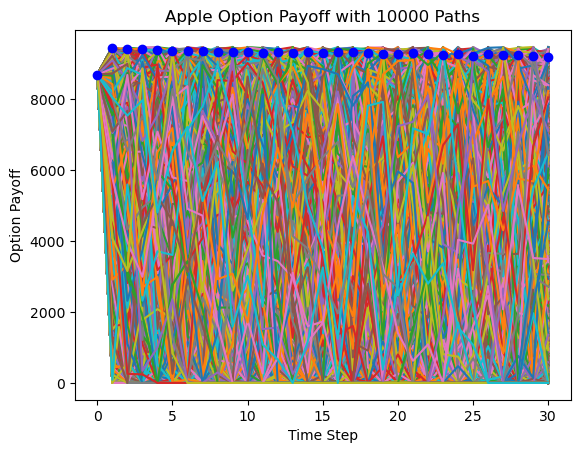

PFE (No CSA) at 1y2y bucket is: 9,327, 5% of notional.


In [52]:
# Obtain PFE profile
PFE_noCSA = np.percentile(MtF, 99, axis=1, method="closest_observation")

plt.plot(MtF)
plt.plot(PFE_noCSA, "bo")
plt.title("Apple Option Payoff with 10000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Option Payoff")
plt.show()

print("PFE (No CSA) at 1y2y bucket is: {:,.0f}, {:.0f}% of notional.".format(np.max(PFE_noCSA[9:31]), np.max(PFE_noCSA[9:31])/notional *100))

And the normal CVaR will be:

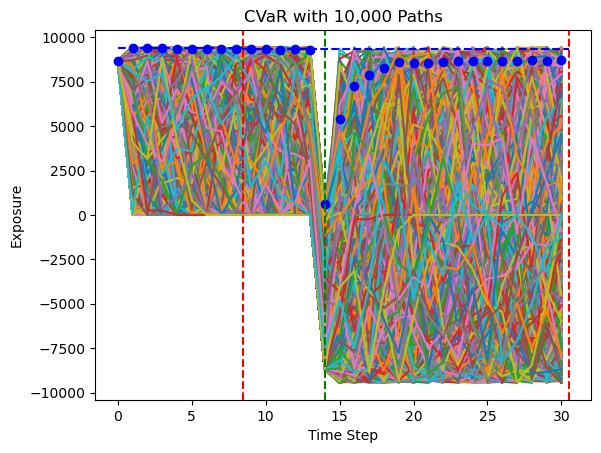

CVaR at 8d1m bucket is: 9,327, 5% of notional.


In [53]:
# plt.figure(figsize=(10, 8))
plt.plot(Expo)
plt.plot(PFE, "bo")

plt.axvline(x = 8.5, color="r", linestyle="dashed")
plt.axvline(x = 30.5, color="r", linestyle="dashed")
plt.axvline(x = MPOR, color="g", linestyle="dashed")
plt.hlines(y = CVaR["0d8d"], xmin=0.0, xmax=8.5, color='b', linestyle="dashed")
plt.hlines(y = CVaR["8d1m"], xmin=8.5, xmax=30.5, color='b', linestyle="dashed")

plt.title("CVaR with 10,000 Paths")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

print("CVaR at 8d1m bucket is: {:,.0f}, {:.0f}% of notional.".format(CVaR.loc[0,"8d1m"], CVaR.loc[0,"8d1m"]/notional *100))

As the simulation will basically cover all scenarios, so scenarios jumping from \\$180 to \\$190 or from \\$200 to \\$190 are always there. The stock path itself is probably not an extreme 99%tile move, but we can find the 99%tile payoff from these paths.

In our example, CVaR has correctly capture the maximum $10 loss we could face, while the stress test scenario basically are not calibrated for this kind of trade.

Again, for this kind of case stress testing is not working well, as it doesn't consider a potential future scenario that the underlying is shocked within a specific range. Therefore, it is important to have CVaR as a complement.

#### **Example 4 - Time Horizon for shocks** ####

Another limitation is that we always need to define a horizon of stress test scenario i.e. the length of period for calibrating the shock. On the other hand, PFE approach will simply simulate the portfolio the whole tenor of the portfolio.

For metrics like STT_M/STT_S we could define both short term and long term. For example, under the long term scenario for "Global Financial Crisis", we have calibrated the shock for emerging FX to ~30%, which is quite conservative for this asset class.

However, this pre-defined horizon just won't suit every cases. For example, let's consider we have traded a 5Y USDJPY FX swap with a corporate client to hedge their long term business. Corporate clients usually won't sign CSA with us, so we won't be protected by collateral.

USDJPY is a G10 FX pair so we probably won't consider it has a high risk. Moreover, even the long term scenario in stress test probably won't consider a long horizon as 5Y.

Yet, if we use a PFE approach, we will allow the USDJPY FX rate to diffuse for 5Y, and will give us a shift even greater than 30%. Although this sounds conservative, please note that in reality USDJPY does have appreciated for 50% from 2021 to 2024!

## 4. Credit Risk and Collateral ##

Now we should be clear how CCR exposure is computed in general. It represents the current value (i.e. MtM) of the portfolio plus a potential movement.

We have already introduced the Variation Margin (VM) mechanism, which covers the MtM part, and also restrict potential movement within the MPOR (14 days).

We also know that even with VM to mitigate part of the credit risk, we are still exposed to the potential movement (e.g. CVaR). In some cases (e.g. trading with Hedge Fund, which usually has a low credit rating), we may want to mitigate this risk as well, and that's we introduce another mechanism - **Initial Margin (IM)**, **Independent Amount (IA)** and **Haircut**.

All IM, IA and Haircut act as a security deposit to protect our bank from the "potential movement". If the counterpart doesn't default, we will just return this security deposit to them when they close out the position. Let's have a closer look at these three collateral.

#### Initial Margin (IM) ####

- A **dynamic** collateral at **portfolio level**, that takes into account all netting effects and is recomputed on a daily basis.
- It is a mandatory requirement for the big financial institutions.
- Specific legal agreement need to be signed to make this effective.
- It is more a regulatory requirement to mitigate the system risk in the market. We have some standard method like "SIMM" available.

#### Independent Amount (IA) ####

- A **static** collateral at **transaction level**, which is determined at the start of the transaction and won't change during its life.
- Moreover, its amount is calibrated by only considering the transaction itself, that we mean we don't allow netting benefit across transactions.
- Specific terms need to state clearly in the VM CSA to make it effective. It could be netted with VM in a margin call, or seggregated (exchange separately).
- It is more economic, and is negotiated as a business decision. It could be case by case, depend on the relationship with our client, and also depend on the risk appetite determined by Credit Analyst.
- **Calibrating IA**
  - A good way to calibrating IA would be using the standalone PFE of the transaction. As explained before, it resolves any limitation of the usual "shock impact" approach.
  - However, as it requires heavy modelling assumption (e.g. underlying distribution, calibration of model), it is not easy to explain and convince our counterpart to accept our methodology. Therefore, we may end up using the old school approach after all.
  - Though the "shock impact" approach seems easy to implement, how to define the shock for products with special payoff (e.g. Butterfly Spread) and how to convince the counterpart could still be challenging.
- **Limitation of IA**
  - When we see IA is at trade level, it seems to be conservative when we have opposite position that net off each other.
  - Notwithstanding this benefit, the "static" nature of IA is in fact detrimental.
  - Take equity forward (or TRS) as an example, initially we may be charging an IA high as 50%. However, during the life of trade, the stock price may just has tripled, and with same amount of IA, it could now just cover a 17% shock.
  - Banks has in fact suffer from this risk in the famous Archegos case.

#### Haircut ####

- The collateral we received are not necessary cash, but could sometime be securities. E.g. the bonds we received in a reverse repo (or other security financing trade) or the equity / commodity securities that we hold in a prime brokerage (agency) account.
- As the security collateral itself could also have a "potential movement", we need to apply a haircut to cover this risk.
- For example, if we require a \\$80m collateral from our counterpart, they will need to post a bond with \\$100m market value if we assume a 20% haircut.
- **Correlation of Collateral and Exposure**
  - For cases like security financing and prime brokerage, the collateral itself has a direct correlation with the trade value, so it is important to consider the potential movement of collateral.

#### Closer look on Credit Risk ####

From the previous section you should realize that CCR exposure itself (either PFE or stress test) does not depend on the credit quality of the counterpart. No matter it is a small hedge fund or a big international bank, with the exact same trade, we will get the exact same exposure.

However, our risk management on CCR shouldn't be too remote from the pure credit risk part. To take into account the credit profile part, we can computed an "**Expected Loss**" by multiplying **Probability of Default (PD)** and  **Loss Given Default (LGD)**, which  is exactly what RWA are trying to do. 

#### Correlation of PD and Exposure - Wrong Way Risk ####

One important  hidden risk in CCR is the **Wrong Way Risk (WWR)**. For instance, when a Chinese counterpart longs some Chinese onshore stock with leverage, under a China crisis scenario, both the PD and the CCR exposure will increase, and our 99%tile may not be conservative enough. i.e. $ P(PFE_{99\%}) = 1\% $ but $ P(PFE_{99\%}|default + WWR) > 1\% $. It is important to identify these positions and closely monitor on them.


## 5. EE, EEE, EEPE and CVA ##

We have introduced both PFE and Stress Test method to calculate a conservative level (e.g. 99%tile) of "potential movement". This could be viewed as the "**Unexpected Credit Exposure**". 

In fact, we also have metrics like EEPE and CVA to capture the "**Expected Credit Exposure**". These metrics could be grouped with PFE as the "simulation family", as their computation relies on Monte Carlo Simulation as well.

Instead of taking a 99%tile, these metrics are taking just the average of the positive MtF. Let's see their definition.

Denote: time ($t$, $T$) & path ($i$, $N$)

Collateral Balance:

$$ CB_t = VM_t + IM_t + IA_t + Haricut_t $$


Exposure: MtF net collateral

$$ Expo_{t,i} = MtF_{t,i} - CB_{t,i} $$


Expected Exposure (**EE**): Average of positive exposure

$$ EE_{t} = \displaystyle \dfrac{1}{N} \sum_{i}^{N} (Expo_{t,i})^+ $$


Expected Effective Exposure (**EEE**): Rolling maximum of EE

$$ EEE_{t} = \underset{\theta \le t}{sup} (EE_{\theta}) $$


Effective Expected Positive Exposure (**EEPE**): Weight average of EEE by time, up to 1Y

$$ EEPE = \displaystyle\int_{0}^{1Y} EEE_t dt $$


Credit Value Adjustment (**CVA**): Expected Credit Loss, Credit Premium that we charge

$$ CVA = \displaystyle LGD_C \int_{0}^{T} EE_t d{PD_t} $$

$$ CVA = \displaystyle LGD_C \sum_{t}^{T} (EE_{t} * \Delta PD_{t, t-1}) $$


Please note that we have two types of "Expected Value" here. We say "Expected Credit Exposure" is the average across the simulation paths, while "Expected Loss" is the average across PD. i.e. CVA is the "Expected Loss" on "Expected Credit Exposure" while we could make an stress test that is the "Expected Loss" on "Unexpected Credit Exposure".

CVA is in fact the Credit Risk Premium we charge when trading with a counterpart. The risk we have when facing Morgan Stanley and facing a Hedge Fund is of course different. Therefore, we need to embed the CVA in the swap price we quote as a premium. Our internal CVA desk will then use these premium to buy some Credit instrument (e.g. CDS) to hedge the risk.


An interesting article on XVA: https://www.scirp.org/journal/paperinformation?paperid=76056

Going back to our equity swap example, assume no CSA and 2Y tenor, then plot PFE, EE, EEE, EEPE on a same graph with 10 simulation paths:

In [54]:
# Define model parameters
# S0 = price[-1]  # Current Stock Price
S0 = 190
r = 0.05  # Risk-free rate
sigma = 0.35  # Volatility
T = 730/365  # Maturity/time period (in years)

Ite = 10  # Number of simulations (paths)
dt = 1/365  # Time-step

In [55]:
# Simulation of market parameter
np.random.seed(612)
stock_paths = GBM_simulate(S0, r, sigma, T, Ite)
# Simulation of MtF for each path and time step
K = S0 * np.exp(r * T) # Find strike price
MtF = equity_future(stock_paths, K, r, T, 'short')

In [56]:
# Computing Exposure matrix
Expo = MtF
# Obtain PFE profile
PFE = np.percentile(Expo, 99, axis=1, method="closest_observation")

In [57]:
Expo_positive = Expo.copy()
Expo_positive[Expo_positive < 0] = 0
EE = np.mean(Expo_positive, axis=1)
EEE = np.maximum.accumulate(EE)
EEPE = np.mean(EEE[:366])

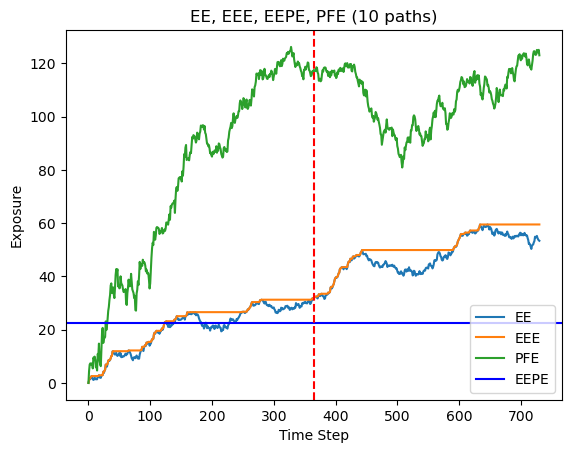

In [58]:
# plt.figure(figsize=(10, 8))
plt.plot(EE)
plt.plot(EEE)
plt.plot(PFE)
plt.axhline(y = EEPE, color='b', linestyle="solid")
plt.axvline(x = 365, color="r", linestyle="dashed")

plt.legend(["EE","EEE","PFE","EEPE"], loc ="lower right")
plt.title("EE, EEE, EEPE, PFE (10 paths)")
plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.show()

## 6. CCR Metrics examples

#### CVaR & GCVaR

- In all the examples we have gone through we didn't consider IM/IA/Haircut. If these collateral exist, what we have computed will in fact be GCVaR

$$ VM_t = MtF_{t - {MPOR}}$$

$$ GCVaR_t = [Q^{99}(MtF_t - VM_t)]^+ $$

$$ CVaR_t = [GCVaR_t - IM_t - IA_t - Haricut_t]^+ $$

$$ CVaR_{[0d8d]} = \underset{0 \le t \le 8}{sup} (CVaR_t) $$

#### WWR CVaR

WWR CVaR is in fact a CVaR with an addtional shock applied to account for WWR, after simulating the market parameters (step 3 in our example).

$$ CB_t = VM_t + IM_t + IA_t + Haricut_t $$

$$ WWRCCR_t = [Q^{99}(MtF_t(WWR \ shock) - CB_t)]^+ $$

#### Multi-Factor Stress Test (STT_M), Single-Factor Stress Test (STT_S)

- In our stress testing example in section 3, it is in fact what STT_S is calculating.
- STT_S is the stressed current exposure calculated by applying a single factor shock. In our example it is Apple stock price down, which represent an "Equity Down" scenario.
  - Single factor could include "Equity Up/Down", "FX Up/Down", "IR Up/Down", "Commodity Up/Down", "Credit Up/Down" etc.
- STT_M is based on a SCE calculated by applying multi factor shock. It first defines a scenario like "Global Financial Crisis", and then calibrate the shocks for all risk factors.
  - For example, a Bond Forward position will be affected by both Credit and IR shocks.

## 7. Organization for CCR

The whole structure of CCR management and teams involved are as follow:
- Modelling / Methodology
  - Just like we have gone through in section 2, Model team defines the model, metric and calibration etc.
- CCR System Calculation
  - The CCR IT team will maintain the CCR systems and pricers
- Exposure Certification
  - The certification team is in charge of the regular certification of CCR metrics
  - In case of limit breach, they will investigate and classify whether it is technical or genuine
- Risk Appetite / Limit Validation
  - They are the Credit Analyst who perform the Annual Credit Review process through regular Due-Diligence Calls with clients
  - They set the CCR limit according to the credit model, all FO needs to comply with their limits
- Active CCR management
  - They are the LOD1 (first line of defense) in FO. When there are any early warning or limit breach, they are responsible to liaise with FO (e.g. Trading) to decide how to resolve the breach.

## 8. Summary

We have gone through the typical CCR metrics and their methodology with concrete examples. Hope you enjoy!

---
Version 1.0, *2024-06*
<span style='color: transparent; font-size:1%'>By Vincent Sin </span>